In [1]:
import os 
from dotenv import load_dotenv
load_dotenv()


True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash', google_api_key = os.getenv('GEMINI_KEY'))
embedding_function = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",  # Correct embedding model
    google_api_key=os.getenv('GEMINI_KEY')
)


In [3]:
from langchain.text_splitter import  RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list =[item for sublist in docs for item in sublist]


text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap = 50)
final_docs = text_splitter.split_documents(docs_list)

vectordb= Chroma.from_documents(final_docs, embedding_function, collection_name='rag-chroma')

retriver = vectordb.as_retriever()



In [4]:
from langchain.tools.retriever import create_retriever_tool
retriver_tool  =create_retriever_tool(retriver, "retriver_blog_post", "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.")



In [5]:
tools = [retriver_tool]


In [6]:
from langchain_core.pydantic_v1 import BaseModel,Field
from langchain_core.prompts import ChatPromptTemplate

class Grade(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score:str=Field(description="Documents are relevant to the question: 'yes' or 'no' ")

structure_llm_output = llm.with_structured_output(Grade)

/home/dev/Desktop/langchain/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
system = """
You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..  
If the document has words or meanings related to the question, mark it as relevant.  
Give a simple 'yes' or 'no' answer to show if the document is relevant or not.
"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ('human',"Retrieved document: \n\n {document} \n\n User question: {question}")
        
    ]
)

In [8]:
my_retrival_grader = prompt |structure_llm_output
docs  = retriver.invoke("what is agent")
print(docs)
text = docs[0].page_content
text

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

'Or\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}'

In [9]:
resposne = my_retrival_grader.invoke({"document":text, 'question':"what is pavan"})
print(resposne)

binary_score='no'


### RAg Chain

In [10]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")


/home/dev/Desktop/langchain/myenv/lib/python3.10/site-packages/langsmith/client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [11]:
rag_chain = prompt|llm

In [12]:
generation = rag_chain.invoke({"context":docs, "question":'what is rohit'})

In [13]:
generation

AIMessage(content='I\'m sorry, but the provided text does not contain information about "Rohit." Therefore, I cannot answer your question.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-7169436d-9851-406c-8949-b956f0ba8499-0', usage_metadata={'input_tokens': 1712, 'output_tokens': 26, 'total_tokens': 1738, 'input_token_details': {'cache_read': 0}})

### Hallucination Grader

In [14]:
class Gradehallucination(BaseModel):
    binary_score:str=Field(description="Answer is grounded in the facts, 'yes' or 'no'")

structure_llm_output = llm.with_structured_output(Gradehallucination)

In [15]:
system = """You are a grader checking if a response generated by an AI is grounded in or supported by a set of retrieved facts.

Respond with "yes" if the generation is factually supported, aligned with, or directly based on the information in the provided facts.

Respond with "no" if the generation includes information that is not present in the facts, contradicts the facts, or makes assumptions beyond what the facts support.

Give a simple "yes" or "no" answer."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human","Set of facts \n\n {documents}  \n\n LLm generation {generation}")
    ]
)

In [16]:
hallucinationgrader = hallucination_prompt|structure_llm_output

In [17]:
resposne= hallucinationgrader.invoke({"documents":docs, "generation":generation})
print(resposne)

binary_score='yes'


### Answer grader

In [18]:
class Answergrader(BaseModel):
    binary_score:str=Field(description="Answer addresses the question, 'yes' or 'no'")


structure_grader = llm.with_structured_output(Answergrader)

system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}")
    ]
)

answergrader = answer_prompt | structure_grader

print(answergrader.invoke({"question":"what is agent", "generation":generation}))

binary_score='no'


### Question Rewriter

In [19]:
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.  
You are given both a question and a document.  
- First, check if the question is relevant to the document by identifying a connection or relevance between them.  
- If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.  
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase 
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""

rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human","""Here is the initial question: \n\n {question} \n,
             Here is the document: \n\n {documents} \n ,
             Formulate an improved question. if possible other return 'question not relevant'.""")
    ]
)
question_rewriter = rewrite_prompt | llm | StrOutputParser()

In [20]:
print(question_rewriter.invoke({"documents":docs, "question":'what is agents'}))

How do LLM-powered autonomous agents function?


### Agent State

In [21]:
from typing import TypedDict, List
class AgentState(TypedDict):
    question:str
    generation:str
    documents:List[str]
    filter_docs:List[str]
    unfilter_docs:List[str]
    

### retriver function

In [22]:
def vector_retriver(state:AgentState):
    question = state["question"]
    documents = retriver.invoke(question)
    return {"question":question, "documents":documents}

In [23]:
resposne = vector_retriver({'question':"whats is agent", "documents":docs})
print(resposne)

{'question': 'whats is agent', 'documents': [Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='Definition: Determine the speaker of the dialogue, "agent" or "customer".\nInput: I have successfully booked your tickets.\nOuput:

### grade documents

In [24]:
def grading_docs(state:AgentState):
    print('------Checking the relevance of the documnets')
    question = state['question']
    documents = state['documents']
    filter_docs =[]
    unfilter_docs=[]

    for doc in documents:
        score = my_retrival_grader.invoke({"question":question, "documents":doc})
        grade = score.binary_score
        print('----- grade----', grade)

        if grade == 'yes':
            print('------doc relevant-----')
            filter_docs.append(doc)
        else:
            print('-------docs are irrelevant-----')
            unfilter_docs.append(doc)

    if len(unfilter_docs)>1:
        return {"unfilter_docs":unfilter_docs, "question":question, "filter_docs":[]}
    else:
        return {"unfilter_docs":[], "question":question, "filter_docs":filter_docs}
    

In [38]:
def decide_or_generate(state:AgentState):
   
    filter_docs = state["filter_docs"]
    unfilter_docs = state['unfilter_docs']


    if unfilter_docs:
        print("All documnets are not relevant")
        return 'transform_query'
    if filter_docs:
        print('----Decision generte')
        return 'generate'



In [39]:
def generate(state:AgentState):
    print("----GENERATE----")
    question=state["question"]
    documents=state["documents"]
    
    generation = rag_chain.invoke({"context": documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation}

In [40]:
from langgraph.graph import END, StateGraph, START
def transform_query(state:AgentState):
    question=state["question"]
    documents=state["documents"]
    
    print(f"this is my document{documents}")
    response = question_rewriter.invoke({"question":question,"documents":documents})
    print(f"----RESPONSE---- {response}")
    if response == 'question not relevant':
        print("----QUESTION IS NOT AT ALL RELEVANT----")
        return {"documents":documents,"question":response,"generation":"question was not at all relevant"}
    else:   
        return {"documents":documents,"question":response}

In [41]:
def decide_to_generate_after_transformation(state:AgentState):
    question=state["question"]
    
    if question=="question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"

In [42]:
import pprint
def grade_generation_vs_documents_and_question(state:AgentState):
    print("---CHECK HELLUCINATIONS---")
    question= state['question']
    documents = state['documents']
    generation = state["generation"]
    
    score = hallucinationgrader.invoke({"documents":documents,"generation":generation})
    
    grade = score.binary_score
    
    #Check hallucinations
    if grade=='yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        
        print("---GRADE GENERATION vs QUESTION ---")
        
        score = answergrader.invoke({"question":question,"generation":generation})
        
        grade = score.binary_score
        
        if grade=='yes':
            print("---DECISION: GENERATION ADDRESS THE QUESTION ---")
            return "useful"
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        "not useful"
    

In [43]:
from langgraph.graph import StateGraph, MessagesState, START, END

workflow = StateGraph(MessagesState)
workflow.add_node("Docs_Vector_retriver", vector_retriver)
workflow.add_edge(START, "Docs_Vector_retriver")
workflow.add_node("Grading_generated_documents", grading_docs)
workflow.add_node("Content_generator", generate)
workflow.add_node('Transform_user_query', transform_query)

In [44]:
workflow.add_edge('Docs_Vector_retriver','Grading_generated_documents')

In [45]:
workflow.add_conditional_edges(
    "Grading_generated_documents",
    decide_or_generate,
    {"generate":"Content_generator", 'transform_query':"Transform_user_query"}

)

In [46]:
workflow.add_conditional_edges(
    'Content_generator',
    grade_generation_vs_documents_and_question,
    {"useful":END, "not_useful":"Transform_user_query"}
)

In [47]:
workflow.add_conditional_edges(
    "Transform_user_query",
    decide_to_generate_after_transformation,
    {"query_not_at_all_relevant":END,"Retriever":"Docs_Vector_retriver"}
)

In [48]:
app = workflow.compile()


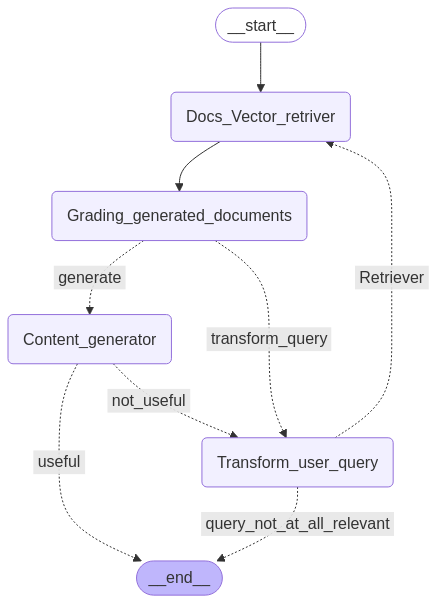

In [49]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [50]:
app.invoke({"question":"what is agent", "documents":docs})

KeyError: 'question'